# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [668]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(10)

# Number of Conditionally independent Factors
num_factors = 3

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits (for efficiency)
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations_test, test_images, test_labels = rearrange_mnist(
    test_data.test_data, 
    test_data.test_labels, 
    num_factors, 
    train_length=test_data.test_labels.shape[0],
    sub_ids=sub_ids
)
test_labels = test_labels.reshape(observations_test[0].shape[0], num_factors)
            

## Move to GPU

In [669]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

Jnoise = 1
observations[Jnoise] += 8 * observations[Jnoise].abs().max() * torch.rand(observations[Jnoise].shape)
observations_test[Jnoise] += 8 * observations_test[Jnoise].abs().max() * torch.rand(observations_test[Jnoise].shape)

# Training Move to GPU
obs = [(obsi / obsi.max()).to(device) for obsi in observations]

# Testing Move to GPU
obs_test = [(obsi / obsi.max()).to(device) for obsi in observations_test]


## Typical Observations

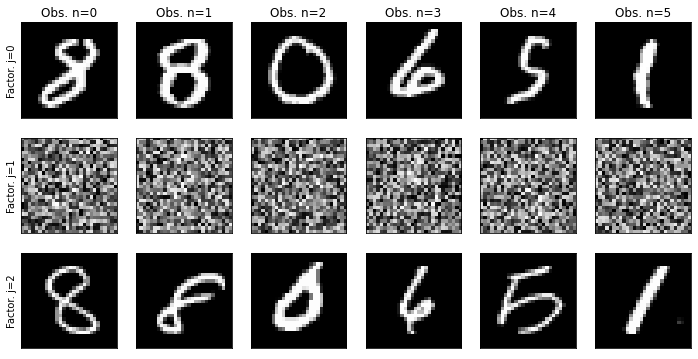

In [670]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(obs[facti][num_plot[obsi], :, :].cpu().numpy(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

## Fit

In [692]:
# Fit params

factors_params = {
    'channels': [[1, 30, 30, 30], [1, 30, 30, 30], [1, 30, 30, 30]],
    'kernel_conv': [[5, 5, 5], [5, 5, 5], [5, 5, 5]],
    'kernel_pool': [[1, 2, 2], [1, 2, 2], [1, 2, 2]],
    'dim_hidden': [[20, 20], [20, 20], [20, 20]],
    'nonlinearity': [F.relu, F.relu, F.relu],
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-4),
    'dropout': [0.2, 0.2, 0.2]
}

auxiliary_params = {
    'optimizer': lambda params: torch.optim.AdamW(params=params, lr=1e-4),
    #'update_bool': False,
}


fit_params = {
    'num_epoch': 10000,
    'batch_size': 1000,
    'auxiliary_update': False,
    'auxiliary_toggle': lambda x: x.epoch > -1,
    'dim_latent': 2,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'pct': 0.01,
}

rpm = RPM(
    observations=obs,
    fit_params=fit_params,
)


RPM on GPU Observations on cuda:0


In [ ]:
rpm.fit(obs)

Toggling Auxiliary Factors Update
Epoch 100/10000 Loss: 1.949362e+01
Epoch 200/10000 Loss: 1.930342e+01
Epoch 300/10000 Loss: 1.917703e+01
Epoch 400/10000 Loss: 1.905566e+01
Epoch 500/10000 Loss: 1.892829e+01
Epoch 600/10000 Loss: 1.882151e+01
Epoch 700/10000 Loss: 1.870199e+01
Epoch 800/10000 Loss: 1.862544e+01
Epoch 900/10000 Loss: 1.859706e+01
Epoch 1000/10000 Loss: 1.853855e+01
Epoch 1200/10000 Loss: 1.842490e+01
Epoch 1300/10000 Loss: 1.839546e+01
Epoch 1400/10000 Loss: 1.836511e+01
Epoch 1500/10000 Loss: 1.833376e+01
Epoch 1600/10000 Loss: 1.828892e+01
Epoch 1700/10000 Loss: 1.826135e+01
Epoch 1800/10000 Loss: 1.825090e+01
Epoch 1900/10000 Loss: 1.822814e+01
Epoch 2000/10000 Loss: 1.819174e+01
Epoch 2100/10000 Loss: 1.818462e+01
Epoch 2200/10000 Loss: 1.817419e+01
Epoch 2300/10000 Loss: 1.815077e+01
Epoch 2400/10000 Loss: 1.814198e+01
Epoch 2500/10000 Loss: 1.812027e+01
Epoch 2600/10000 Loss: 1.809718e+01
Epoch 2700/10000 Loss: 1.810324e+01
Epoch 2800/10000 Loss: 1.806135e+01
Epo

In [680]:
print(0)

0


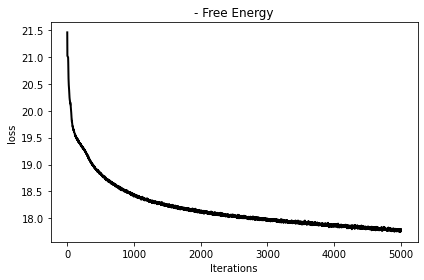

In [688]:
plot_loss(rpm, offset=0)



## Latent Distribution Embeddings of test images

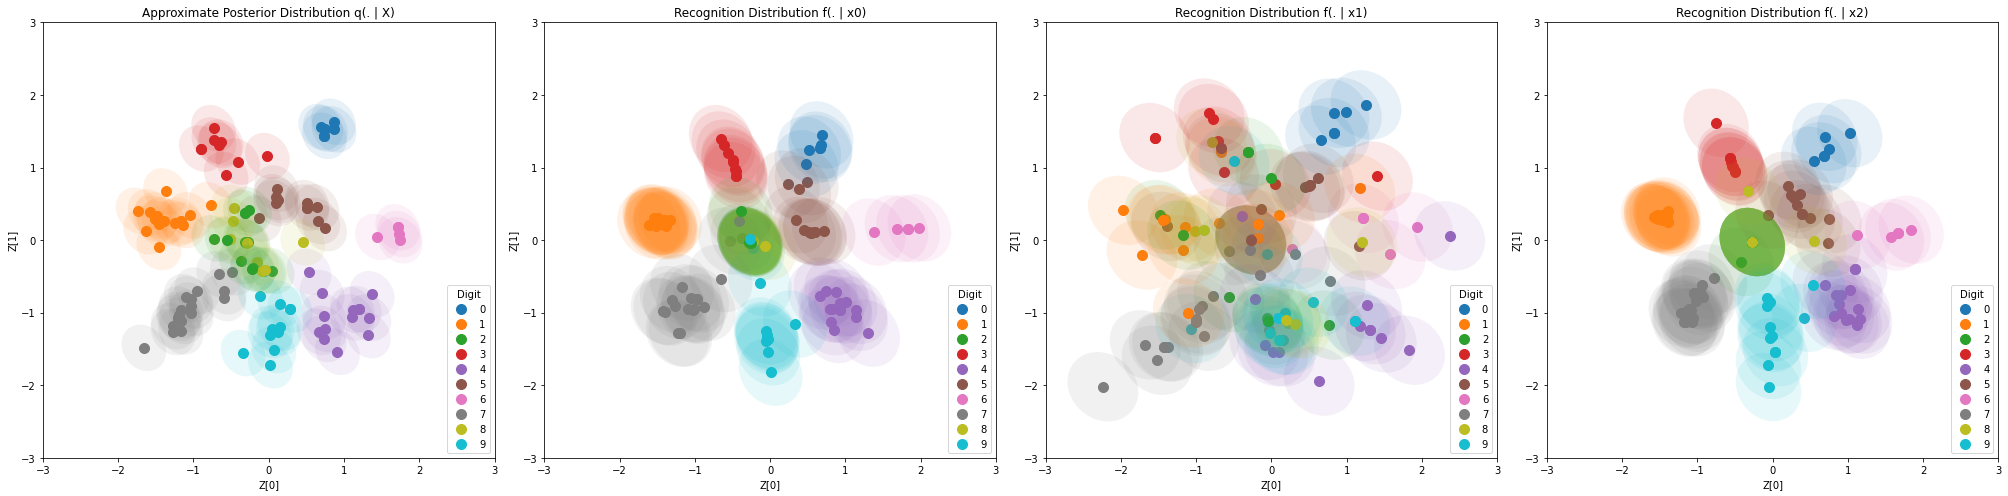

In [689]:
# Forward test data
import utils_process

dim_latent = rpm.dim_latent
heigh = int(dim_latent * (dim_latent - 1) / 2)
width = rpm.num_factors + 1
plt.figure(figsize=(width * 7, heigh * 7))  


for J in range(-1, rpm.num_factors):

    #J = 0
    qdist, fdist = rpm.get_posteriors(obs_test)

    if J == -1:
        mean, vari = qdist.mean_covariance()
        title_str = 'Approximate Posterior Distribution q(. | X)'
    else:
        mean, vari = fdist.mean_covariance()
        mean = mean[J]
        vari = vari[J]
        title_str = 'Recognition Distribution f(. | x' + str(J) + ')'

    mean = mean.detach().clone().cpu().numpy()
    vari = vari.detach().clone().cpu().numpy()


    # Plot testing Data
    subset = 100
    xx = mean[:subset]
    zz = vari[:subset]
    yy = test_labels[:subset, J]
    cmap = plt.get_cmap("tab10")
    
    
    xmaxmin = np.abs(xx).max() + 0.5 * np.sqrt(zz.diagonal(axis1= -1, axis2=-2).max())
    
    compt = 0
    for uu in range(dim_latent -1):
        for vv in range(uu+1, dim_latent):
            offset = width * compt 
            compt += 1
            
            ax = plt.subplot(heigh, width, J + 2 + offset)
            for ii in range(subset):
                y0 = int(yy[ii].numpy())
                x0 = xx[ii]
                z0 = zz[ii]
                plt.scatter(x0[uu], x0[vv], s=100, color=cmap(y0))
                utils_process.confidence_ellipse(x0[[uu, vv]], z0[[uu, vv]][:, [uu, vv]], ax, n_std=1.0, facecolor=cmap(y0), alpha=0.1)
                
            for ii in np.unique(yy):
                y0 = yy[np.where(yy == ii)]
                x0 = xx[np.where(yy == ii)]
                plt.scatter(x0[0, uu], x0[0, vv], s=100, label=str(int(ii)), color=cmap(int(y0[0].numpy())))

            plt.legend(title = 'Digit', loc= 'lower right')
            plt.xlabel('Z[' + str(uu) + ']')
            plt.ylabel('Z[' + str(vv) + ']')
            plt.title(title_str)
            xmaxmin = 3
            plt.xlim([-xmaxmin, xmaxmin])
            plt.ylim([-xmaxmin, xmaxmin])
            plt.tight_layout()

In [690]:
from flexible_multivariate_normal import FlexibleMultivariateNormal

qmean, qvar = qdist.mean_covariance()
fmean, fvar = fdist.mean_covariance()
n1, n2 = [xx.clone().detach() for xx in rpm.forwarded_prior]
pmean, pvar = FlexibleMultivariateNormal(n1, n2, init_cholesky=False, init_natural=True, store_suff_stat_mean=True).mean_covariance()
pmean = pmean.cpu().numpy()
pvar = pvar.cpu().numpy()



In [691]:
print(fvar[:, 0].diagonal(dim1=-1, dim2= -2))
print('')
print(qvar[0].diagonal(dim1=-1, dim2= -2))

tensor([[0.1793, 0.2153],
        [0.2215, 0.2289],
        [0.1893, 0.2221]], device='cuda:0')

tensor([0.0883, 0.1029], device='cuda:0')


In [559]:
dim_latent_true = 1
num_observations = 100
dim_observations = 10
num_factors = 3

zlatent = torch.randn(num_observations, dim_latent_true, device=device)


Jvar = 1
link_factors = torch.rand(num_factors, dim_observations, dim_latent_true, device=device)
vari_factors = torch.eye(dim_observations, device=device).unsqueeze(0).repeat(num_factors, 1, 1)
vari_factors[Jvar] = vari_factors[Jvar] * 0.01

noise = torch.sqrt(vari_factors.diagonal(dim1=-1,dim2=-2).unsqueeze(1)) * torch.randn(num_factors, num_observations, dim_observations, device=device)
observations = torch.matmul(link_factors.unsqueeze(1), zlatent.unsqueeze(0).unsqueeze(-1)).squeeze(-1) + noise
observations = [obsi for obsi in observations]

In [560]:
# Fit params

factors_params = {
    'dim_hidden': [[], [], []],
    'nonlinearity': [torch.nn.Identity, torch.nn.Identity, torch.nn.Identity],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

auxiliary_params = {
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'update_bool': False,
}


fit_params = {
    'num_epoch': 10000,
    'auxiliary_update': False,
    'auxiliary_toggle': lambda x: x.epoch < -2,
    'dim_latent': dim_latent_true,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'pct': 0.1,
}

rpm = RPM(
    observations=observations,
    fit_params=fit_params,
)

rpm.fit(observations)

RPM on GPU Observations on cuda:0
Epoch 1000/10000 Loss: 1.255545e+01
Epoch 2000/10000 Loss: 1.237501e+01
Epoch 3000/10000 Loss: 1.231544e+01
Epoch 4000/10000 Loss: 1.229167e+01
Epoch 5000/10000 Loss: 1.228024e+01
Epoch 6000/10000 Loss: 1.227353e+01
Epoch 7000/10000 Loss: 1.226868e+01
Epoch 8000/10000 Loss: 1.226467e+01
Epoch 9000/10000 Loss: 1.226104e+01
Epoch 10000/10000 Loss: 1.225770e+01


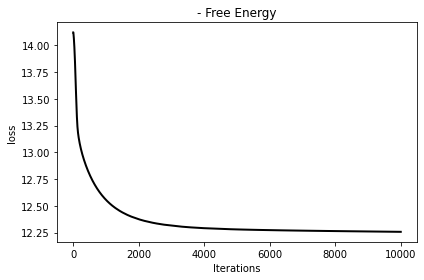

In [562]:
plot_loss(rpm, offset=0)

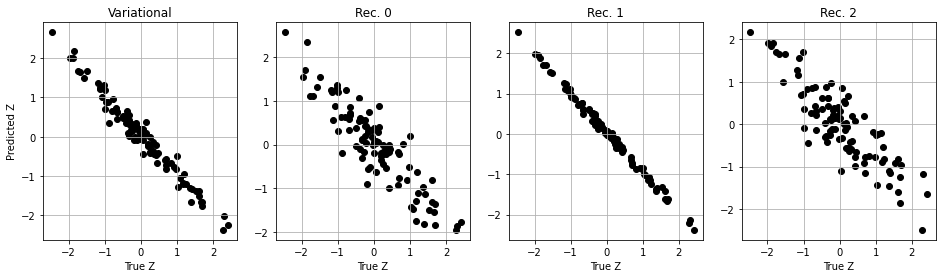

In [563]:

qdist, fdist = rpm.get_posteriors(observations)
qmean = qdist.mean_covariance()[0].to("cpu")
fmean = [fi.to("cpu") for fi in fdist.mean_covariance()[0]]

qvar = qdist.mean_covariance()[1][0].to("cpu")
fvar = [fi[0].to("cpu") for fi in fdist.mean_covariance()[1]]



plot_mean = [qmean, *fmean]
plot_var = [qvar, *fvar]
plot_title = ['Variational', *['Rec. ' + str(ii) for ii,_ in enumerate(fmean) ]]

width = len(plot_mean)
heigh = 1
tru_posi = zlatent.to("cpu")

plt.figure(figsize=(width * 4, heigh * 4))
for ii, xmean in enumerate(plot_mean):
    plt.subplot(heigh, width, ii + 1)
    #plt.scatter(tru_posi, plot_mean[0], c='b')
    plt.scatter(tru_posi, xmean, c='k')
    plt.xlabel('True Z')
    if ii == 0:
        plt.ylabel('Predicted Z')
    plt.title(plot_title[ii])
    plt.grid()

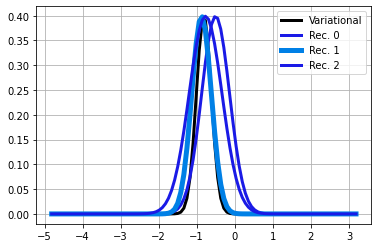

In [564]:
eg = 10
eg_mean = [mean[eg] for mean in plot_mean]
eg_vari = plot_var


tt_mean = tru_posi[eg].numpy()[0]
tt_mean = eg_mean[0].numpy()[0]

zmm = 4
zeval = torch.linspace(tt_mean-zmm, tt_mean + zmm, 100)

def gdensity1D(mean, sigma2):
    def func(z):
        return torch.exp( - 0.5 * (z- mean) ** 2 / sigma2) / torch.sqrt(2 * torch.tensor(np.pi))

    return func


colors = [
    [0.0, 0.0, 0.0],
    [0.1, 0.1, 0.9],
    [0.0, 0.5, 0.9],
    [0.1, 0.1, 0.9],
]

linewidths = [3, 3, 5, 3]

plt.figure()
for ii, xmean in enumerate(eg_mean):
    
    xvari = eg_vari[ii] 
    dens = gdensity1D(xmean, xvari)(zeval).squeeze()

    plt.plot(zeval, dens, label= plot_title[ii], c=colors[ii], lw = linewidths[ii])
    
#plt.axvline(x = tt_mean, color = 'k', label = 'True Value')
plt.grid()
plt.legend()

In [565]:
eg_vari

[tensor([[0.0390]]),
 tensor([[0.1353]]),
 tensor([[0.0671]]),
 tensor([[0.1875]])]

In [558]:
fdist.mean_covariance()[1][:, 0]

tensor([[[0.2530]],

        [[0.0734]],

        [[0.0925]]], device='cuda:0')